TODOS
 - add non-NLM neural net to compare against as well
 - normalize X and Y before tuning
 - try tanh activation
 - send nlm implementation to cooper with all hyperparameters
 - decomposing nlm final output and bayesian conf intervals
 - hyperparameter tuning is too specific to each dataset

In [ ]:
# import standard libraries
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# import our libraries
import bayes_helpers as bh
from utils import generate_data, run_toy_nn
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

### Generate Cubic Dataset

Generates 100 datapoints for train and 100 points for test according to the function

$$y = \frac{1}{2}x^3 + \epsilon$$

$$\epsilon \sim N(0, 3^2)$$

In [2]:
x_train, y_train, x_test = generate_data()

### Define Hyperameters

In [3]:
####  activation ####
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

#### LUNA NN structure ####
width = 5
hidden_layers = 2
input_dim = 1
output_dim = 5 #number of auxiliary functions
architecture = {'width': width,
            'hidden_layers': hidden_layers,
            'input_dim': input_dim,
            'output_dim': output_dim,
            'activation_fn_type': activation_fn_type,
            'activation_fn_params': 'rate=1',
            'activation_fn': activation_fn}

#### optimization parameters ####
step_size = 1e-3
num_iterations = 100

optimization_params = {'step_size':step_size, 
          'max_iteration':num_iterations, 
          'random_restarts':1,
          'optimizer':'adam'}

#### objective function parameters ####

regularization_param_nlm = 8.37 #they chose this in the paper, what a beautifully specific number

# in the paper they searched over 1e-3,...,1e3 and chose 1e-1 for regularization

regularization_param_luna = 1e-1

# in the paper they searched over 1e-3,...,1e3 and chose 1e0 for similarity

similarity_param = 1e0

#### other parameters ####
prior_variance = 1 # chosen in the paper. declared "reasonable". who decided this
y_noise_variance = 9 # needs to match what the dataset itself is
random = np.random.RandomState(0)

In [4]:
t0 = time.time()
nlm = NLM(prior_variance,y_noise_variance, regularization_param_nlm, architecture, random)
nlm.train(x_train,y_train, optimization_params)
nlm_time = np.round(time.time() - t0, 3)

 Iteration 0 lower bound 375372.1908091865; gradient mag: 335057.1868149343
Done Training


In [5]:
t0 = time.time()
luna = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, architecture, random)
luna.train(x_train, y_train, optimization_params)
luna_time = np.round(time.time() - t0, 3)


 Iteration 0 lower bound 2003.6507053397565; gradient mag: 914.3143673210062
Done Training


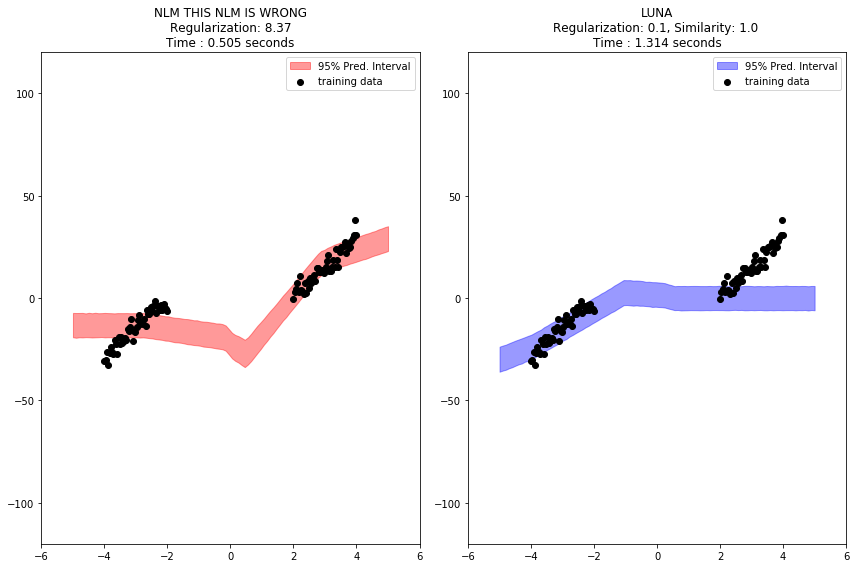

In [6]:
#### predict on the test x-values ####
nlm_posterior_predictions, nlm_posterior_predictive_samples = nlm.predict(x_test)
nlm_lower, nlm_mean, nlm_upper = bh.get_percentile_interval(nlm_posterior_predictive_samples)

luna_posterior_predictions, luna_posterior_predictive_samples = luna.predict(x_test)
luna_lower, luna_mean, luna_upper = bh.get_percentile_interval(luna_posterior_predictive_samples)
######################################


fig, ax = plt.subplots(1,2, figsize = (12, 8))

# title = f'$f(x) = 0.5x^3 + \epsilon$,    $\epsilon$ ~ N(0, {y_noise_variance})\n'
# title += f'Activation function: {activation_fn_type}\n'
# title += f'Width: {width}\n'
# title += f'# Hidden layers: {hidden_layers}\n'
# title += f'# Auxiliary functions: {output_dim}\n'
# title += f'Variance Prior: {prior_variance}\n'
# title += f'Optimized for {num_iterations} iterations with step size {step_size}'
# fig.suptitle(title, fontsize = 15)

ax[0].plot(x_test, nlm_mean, color='red') # visualize the mean of the posterior predictive
ax[0].fill_between(x_test.reshape(-1), nlm_upper, nlm_lower, color='red', alpha=0.4, label='95% Pred. Interval') # visualize the 95% posterior predictive interval
ax[0].scatter(x_train, y_train, color='black', label='training data') # visualize the training data
ax[0].legend()
ax[0].set_title(f'NLM THIS NLM IS WRONG\nRegularization: {regularization_param_nlm}\nTime : {nlm_time} seconds')
ax[0].set_xlim([-6, 6])
ax[0].set_ylim([-120, 120])

ax[1].plot(x_test, luna_mean, color='blue') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test.reshape(-1), luna_upper, luna_lower, color='blue', alpha=0.4, label='95% Pred. Interval') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train, y_train, color='black', label='training data') # visualize the training data
ax[1].legend()
ax[1].set_title(f'LUNA\nRegularization: {regularization_param_luna}, Similarity: {similarity_param} \nTime : {luna_time} seconds')
ax[1].set_xlim([-6, 6])
ax[1].set_ylim([-120, 120])
plt.tight_layout()
plt.show()

other notes: 
 - trained on 100 points
 